In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [2]:
# Load the dataset from a CSV file
df = pd.read_csv('data.csv')

# Display the first few rows to ensure data is loaded correctly
df.head()




,input_text,output_text
0,look around,look
1,examine room,look
2,inspect surroundings,look
3,survey the area,look
4,observe closely,look


In [3]:
# Extract source and target texts
source_texts = df['input_text'].values
target_texts = df['output_text'].values

In [4]:
# Initialize Tokenizers
source_tokenizer = Tokenizer()
target_tokenizer = Tokenizer()

# Fit tokenizers on the data
source_tokenizer.fit_on_texts(source_texts)
target_tokenizer.fit_on_texts(target_texts)

# Add special tokens to target tokenizer
target_tokenizer.word_index['<start>'] = len(target_tokenizer.word_index) + 1
target_tokenizer.word_index['<end>'] = len(target_tokenizer.word_index) + 1
target_tokenizer.index_word[target_tokenizer.word_index['<start>']] = '<start>'
target_tokenizer.index_word[target_tokenizer.word_index['<end>']] = '<end>'

# Convert text to sequences
source_sequences = source_tokenizer.texts_to_sequences(source_texts)
target_sequences = target_tokenizer.texts_to_sequences(target_texts)


In [5]:
# Determine the maximum sequence lengths
max_source_len = max(len(seq) for seq in source_sequences)
max_target_len = max(len(seq) for seq in target_sequences)

# Pad the sequences
source_sequences = pad_sequences(source_sequences, maxlen=max_source_len, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_target_len, padding='post')

# Prepare the input and output for training
X_train = np.array(source_sequences)

# Decoder input: Exclude the last token
y_train_input = np.array(target_sequences[:, :-1])

# Decoder output: Exclude the first token
y_train_output = np.array(target_sequences[:, 1:])

# Check the shapes of the prepared data
print(f"X_train shape: {X_train.shape}")
print(f"y_train_input shape: {y_train_input.shape}")
print(f"y_train_output shape: {y_train_output.shape}")


X_train shape: (81, 3)
y_train_input shape: (81, 1)
y_train_output shape: (81, 1)


In [6]:
# Define the model architecture
embedding_dim = 100  # Set embedding dimension
latent_dim = 256  # LSTM units

# Encoder
encoder_inputs = Input(shape=(max_source_len,))
encoder_embedding = Embedding(input_dim=len(source_tokenizer.word_index) + 1,
                               output_dim=embedding_dim,
                               input_length=max_source_len)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_target_len - 1,))
decoder_embedding = Embedding(input_dim=len(target_tokenizer.word_index) + 1,
                               output_dim=embedding_dim,
                               input_length=max_target_len - 1)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(len(target_tokenizer.word_index) + 1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 3, 100)               13800     ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 100)               2200      ['input_2[0][0]']             
                                                                                              

In [7]:
# Train the model
history = model.fit(
    [X_train, y_train_input],  # Input sequence and shifted target sequence
    np.expand_dims(y_train_output, -1),  # Target output (next token prediction)
    batch_size=2048,
    epochs=2000,
    validation_split=0.2
)


Epoch 1/2000
1/1 [==============================] - 3s 3s/step - loss: 3.0934 - accuracy: 0.0000e+00 - val_loss: 3.0746 - val_accuracy: 0.8824
Epoch 2/2000
1/1 [==============================] - 0s 27ms/step - loss: 3.0747 - accuracy: 0.6094 - val_loss: 3.0514 - val_accuracy: 1.0000
Epoch 3/2000
1/1 [==============================] - 0s 23ms/step - loss: 3.0555 - accuracy: 0.5469 - val_loss: 3.0261 - val_accuracy: 1.0000
Epoch 4/2000
1/1 [==============================] - 0s 27ms/step - loss: 3.0349 - accuracy: 0.5156 - val_loss: 2.9977 - val_accuracy: 1.0000
Epoch 5/2000
1/1 [==============================] - 0s 30ms/step - loss: 3.0120 - accuracy: 0.5000 - val_loss: 2.9649 - val_accuracy: 1.0000
Epoch 6/2000
1/1 [==============================] - 0s 25ms/step - loss: 2.9858 - accuracy: 0.5000 - val_loss: 2.9265 - val_accuracy: 1.0000
Epoch 7/2000
1/1 [==============================] - 0s 23ms/step - loss: 2.9554 - accuracy: 0.5000 - val_loss: 2.8814 - val_accuracy: 1.0000
Epoch 8/200

Epoch 59/2000
1/1 [==============================] - 0s 27ms/step - loss: 0.6862 - accuracy: 0.7969 - val_loss: 1.2575 - val_accuracy: 0.3529
Epoch 60/2000
1/1 [==============================] - 0s 27ms/step - loss: 0.6685 - accuracy: 0.8281 - val_loss: 1.2846 - val_accuracy: 0.3529
Epoch 61/2000
1/1 [==============================] - 0s 27ms/step - loss: 0.6506 - accuracy: 0.8281 - val_loss: 1.3059 - val_accuracy: 0.2353
Epoch 62/2000
1/1 [==============================] - 0s 29ms/step - loss: 0.6326 - accuracy: 0.8438 - val_loss: 1.3210 - val_accuracy: 0.1765
Epoch 63/2000
1/1 [==============================] - 0s 25ms/step - loss: 0.6146 - accuracy: 0.8438 - val_loss: 1.3301 - val_accuracy: 0.1765
Epoch 64/2000
1/1 [==============================] - 0s 24ms/step - loss: 0.5967 - accuracy: 0.8438 - val_loss: 1.3335 - val_accuracy: 0.1765
Epoch 65/2000
1/1 [==============================] - 0s 28ms/step - loss: 0.5790 - accuracy: 0.8594 - val_loss: 1.3321 - val_accuracy: 0.1765
Epoch 

1/1 [==============================] - 0s 27ms/step - loss: 0.2361 - accuracy: 0.9062 - val_loss: 1.0284 - val_accuracy: 0.4706
Epoch 117/2000
1/1 [==============================] - 0s 27ms/step - loss: 0.2307 - accuracy: 0.9062 - val_loss: 1.0184 - val_accuracy: 0.4706
Epoch 118/2000
1/1 [==============================] - 0s 24ms/step - loss: 0.2252 - accuracy: 0.9062 - val_loss: 1.0082 - val_accuracy: 0.4706
Epoch 119/2000
1/1 [==============================] - 0s 26ms/step - loss: 0.2197 - accuracy: 0.9531 - val_loss: 0.9981 - val_accuracy: 0.4706
Epoch 120/2000
1/1 [==============================] - 0s 25ms/step - loss: 0.2142 - accuracy: 0.9531 - val_loss: 0.9881 - val_accuracy: 0.4706
Epoch 121/2000
1/1 [==============================] - 0s 23ms/step - loss: 0.2086 - accuracy: 0.9531 - val_loss: 0.9781 - val_accuracy: 0.5294
Epoch 122/2000
1/1 [==============================] - 0s 30ms/step - loss: 0.2030 - accuracy: 0.9531 - val_loss: 0.9680 - val_accuracy: 0.5294
Epoch 123/2000

1/1 [==============================] - 0s 28ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.5644 - val_accuracy: 0.8824
Epoch 174/2000
1/1 [==============================] - 0s 24ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.5613 - val_accuracy: 0.8824
Epoch 175/2000
1/1 [==============================] - 0s 24ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.5585 - val_accuracy: 0.8824
Epoch 176/2000
1/1 [==============================] - 0s 22ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.5557 - val_accuracy: 0.8824
Epoch 177/2000
1/1 [==============================] - 0s 28ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.5531 - val_accuracy: 0.8824
Epoch 178/2000
1/1 [==============================] - 0s 24ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.5507 - val_accuracy: 0.8824
Epoch 179/2000
1/1 [==============================] - 0s 23ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.5484 - val_accuracy: 0.8824
Epoch 180/2000

1/1 [==============================] - 0s 25ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.5025 - val_accuracy: 0.8824
Epoch 231/2000
1/1 [==============================] - 0s 22ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.5021 - val_accuracy: 0.8824
Epoch 232/2000
1/1 [==============================] - 0s 29ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.5018 - val_accuracy: 0.8824
Epoch 233/2000
1/1 [==============================] - 0s 28ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.5016 - val_accuracy: 0.8824
Epoch 234/2000
1/1 [==============================] - 0s 27ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.5012 - val_accuracy: 0.8824
Epoch 235/2000
1/1 [==============================] - 0s 24ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.5009 - val_accuracy: 0.8824
Epoch 236/2000
1/1 [==============================] - 0s 24ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.5007 - val_accuracy: 0.8824
Epoch 237/2000

1/1 [==============================] - 0s 24ms/step - loss: 7.0381e-04 - accuracy: 1.0000 - val_loss: 0.4927 - val_accuracy: 0.8824
Epoch 287/2000
1/1 [==============================] - 0s 25ms/step - loss: 6.9771e-04 - accuracy: 1.0000 - val_loss: 0.4926 - val_accuracy: 0.8824
Epoch 288/2000
1/1 [==============================] - 0s 26ms/step - loss: 6.9183e-04 - accuracy: 1.0000 - val_loss: 0.4926 - val_accuracy: 0.8824
Epoch 289/2000
1/1 [==============================] - 0s 24ms/step - loss: 6.8608e-04 - accuracy: 1.0000 - val_loss: 0.4925 - val_accuracy: 0.8824
Epoch 290/2000
1/1 [==============================] - 0s 26ms/step - loss: 6.8022e-04 - accuracy: 1.0000 - val_loss: 0.4923 - val_accuracy: 0.8824
Epoch 291/2000
1/1 [==============================] - 0s 26ms/step - loss: 6.7463e-04 - accuracy: 1.0000 - val_loss: 0.4923 - val_accuracy: 0.8824
Epoch 292/2000
1/1 [==============================] - 0s 24ms/step - loss: 6.6905e-04 - accuracy: 1.0000 - val_loss: 0.4922 - val_acc

Epoch 342/2000
1/1 [==============================] - 0s 25ms/step - loss: 4.6614e-04 - accuracy: 1.0000 - val_loss: 0.4895 - val_accuracy: 0.8824
Epoch 343/2000
1/1 [==============================] - 0s 24ms/step - loss: 4.6322e-04 - accuracy: 1.0000 - val_loss: 0.4895 - val_accuracy: 0.8824
Epoch 344/2000
1/1 [==============================] - 0s 26ms/step - loss: 4.6029e-04 - accuracy: 1.0000 - val_loss: 0.4894 - val_accuracy: 0.8824
Epoch 345/2000
1/1 [==============================] - 0s 23ms/step - loss: 4.5740e-04 - accuracy: 1.0000 - val_loss: 0.4895 - val_accuracy: 0.8824
Epoch 346/2000
1/1 [==============================] - 0s 28ms/step - loss: 4.5456e-04 - accuracy: 1.0000 - val_loss: 0.4894 - val_accuracy: 0.8824
Epoch 347/2000
1/1 [==============================] - 0s 25ms/step - loss: 4.5171e-04 - accuracy: 1.0000 - val_loss: 0.4894 - val_accuracy: 0.8824
Epoch 348/2000
1/1 [==============================] - 0s 25ms/step - loss: 4.4893e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 398/2000
1/1 [==============================] - 0s 24ms/step - loss: 3.3885e-04 - accuracy: 1.0000 - val_loss: 0.4882 - val_accuracy: 0.8824
Epoch 399/2000
1/1 [==============================] - 0s 25ms/step - loss: 3.3710e-04 - accuracy: 1.0000 - val_loss: 0.4882 - val_accuracy: 0.8824
Epoch 400/2000
1/1 [==============================] - 0s 26ms/step - loss: 3.3539e-04 - accuracy: 1.0000 - val_loss: 0.4882 - val_accuracy: 0.8824
Epoch 401/2000
1/1 [==============================] - 0s 27ms/step - loss: 3.3370e-04 - accuracy: 1.0000 - val_loss: 0.4882 - val_accuracy: 0.8824
Epoch 402/2000
1/1 [==============================] - 0s 23ms/step - loss: 3.3203e-04 - accuracy: 1.0000 - val_loss: 0.4882 - val_accuracy: 0.8824
Epoch 403/2000
1/1 [==============================] - 0s 26ms/step - loss: 3.3035e-04 - accuracy: 1.0000 - val_loss: 0.4882 - val_accuracy: 0.8824
Epoch 404/2000
1/1 [==============================] - 0s 26ms/step - loss: 3.2871e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 454/2000
1/1 [==============================] - 0s 25ms/step - loss: 2.6053e-04 - accuracy: 1.0000 - val_loss: 0.4878 - val_accuracy: 0.8824
Epoch 455/2000
1/1 [==============================] - 0s 26ms/step - loss: 2.5942e-04 - accuracy: 1.0000 - val_loss: 0.4878 - val_accuracy: 0.8824
Epoch 456/2000
1/1 [==============================] - 0s 29ms/step - loss: 2.5829e-04 - accuracy: 1.0000 - val_loss: 0.4878 - val_accuracy: 0.8824
Epoch 457/2000
1/1 [==============================] - 0s 27ms/step - loss: 2.5720e-04 - accuracy: 1.0000 - val_loss: 0.4878 - val_accuracy: 0.8824
Epoch 458/2000
1/1 [==============================] - 0s 23ms/step - loss: 2.5610e-04 - accuracy: 1.0000 - val_loss: 0.4877 - val_accuracy: 0.8824
Epoch 459/2000
1/1 [==============================] - 0s 25ms/step - loss: 2.5502e-04 - accuracy: 1.0000 - val_loss: 0.4877 - val_accuracy: 0.8824
Epoch 460/2000
1/1 [==============================] - 0s 27ms/step - loss: 2.5396e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 510/2000
1/1 [==============================] - 0s 26ms/step - loss: 2.0816e-04 - accuracy: 1.0000 - val_loss: 0.4876 - val_accuracy: 0.8824
Epoch 511/2000
1/1 [==============================] - 0s 24ms/step - loss: 2.0738e-04 - accuracy: 1.0000 - val_loss: 0.4876 - val_accuracy: 0.8824
Epoch 512/2000
1/1 [==============================] - 0s 24ms/step - loss: 2.0661e-04 - accuracy: 1.0000 - val_loss: 0.4876 - val_accuracy: 0.8824
Epoch 513/2000
1/1 [==============================] - 0s 26ms/step - loss: 2.0586e-04 - accuracy: 1.0000 - val_loss: 0.4876 - val_accuracy: 0.8824
Epoch 514/2000
1/1 [==============================] - 0s 24ms/step - loss: 2.0510e-04 - accuracy: 1.0000 - val_loss: 0.4877 - val_accuracy: 0.8824
Epoch 515/2000
1/1 [==============================] - 0s 24ms/step - loss: 2.0431e-04 - accuracy: 1.0000 - val_loss: 0.4877 - val_accuracy: 0.8824
Epoch 516/2000
1/1 [==============================] - 0s 26ms/step - loss: 2.0357e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 566/2000
1/1 [==============================] - 0s 24ms/step - loss: 1.7099e-04 - accuracy: 1.0000 - val_loss: 0.4877 - val_accuracy: 0.8824
Epoch 567/2000
1/1 [==============================] - 0s 26ms/step - loss: 1.7044e-04 - accuracy: 1.0000 - val_loss: 0.4877 - val_accuracy: 0.8824
Epoch 568/2000
1/1 [==============================] - 0s 24ms/step - loss: 1.6986e-04 - accuracy: 1.0000 - val_loss: 0.4877 - val_accuracy: 0.8824
Epoch 569/2000
1/1 [==============================] - 0s 22ms/step - loss: 1.6929e-04 - accuracy: 1.0000 - val_loss: 0.4877 - val_accuracy: 0.8824
Epoch 570/2000
1/1 [==============================] - 0s 23ms/step - loss: 1.6876e-04 - accuracy: 1.0000 - val_loss: 0.4878 - val_accuracy: 0.8824
Epoch 571/2000
1/1 [==============================] - 0s 29ms/step - loss: 1.6821e-04 - accuracy: 1.0000 - val_loss: 0.4878 - val_accuracy: 0.8824
Epoch 572/2000
1/1 [==============================] - 0s 27ms/step - loss: 1.6766e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 622/2000
1/1 [==============================] - 0s 25ms/step - loss: 1.4346e-04 - accuracy: 1.0000 - val_loss: 0.4879 - val_accuracy: 0.8824
Epoch 623/2000
1/1 [==============================] - 0s 24ms/step - loss: 1.4304e-04 - accuracy: 1.0000 - val_loss: 0.4879 - val_accuracy: 0.8824
Epoch 624/2000
1/1 [==============================] - 0s 26ms/step - loss: 1.4261e-04 - accuracy: 1.0000 - val_loss: 0.4879 - val_accuracy: 0.8824
Epoch 625/2000
1/1 [==============================] - 0s 25ms/step - loss: 1.4220e-04 - accuracy: 1.0000 - val_loss: 0.4879 - val_accuracy: 0.8824
Epoch 626/2000
1/1 [==============================] - 0s 27ms/step - loss: 1.4178e-04 - accuracy: 1.0000 - val_loss: 0.4879 - val_accuracy: 0.8824
Epoch 627/2000
1/1 [==============================] - 0s 27ms/step - loss: 1.4138e-04 - accuracy: 1.0000 - val_loss: 0.4879 - val_accuracy: 0.8824
Epoch 628/2000
1/1 [==============================] - 0s 25ms/step - loss: 1.4095e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 678/2000
1/1 [==============================] - 0s 25ms/step - loss: 1.2243e-04 - accuracy: 1.0000 - val_loss: 0.4881 - val_accuracy: 0.8235
Epoch 679/2000
1/1 [==============================] - 0s 23ms/step - loss: 1.2209e-04 - accuracy: 1.0000 - val_loss: 0.4881 - val_accuracy: 0.8235
Epoch 680/2000
1/1 [==============================] - 0s 24ms/step - loss: 1.2175e-04 - accuracy: 1.0000 - val_loss: 0.4881 - val_accuracy: 0.8235
Epoch 681/2000
1/1 [==============================] - 0s 25ms/step - loss: 1.2142e-04 - accuracy: 1.0000 - val_loss: 0.4881 - val_accuracy: 0.8235
Epoch 682/2000
1/1 [==============================] - 0s 27ms/step - loss: 1.2111e-04 - accuracy: 1.0000 - val_loss: 0.4881 - val_accuracy: 0.8235
Epoch 683/2000
1/1 [==============================] - 0s 25ms/step - loss: 1.2079e-04 - accuracy: 1.0000 - val_loss: 0.4881 - val_accuracy: 0.8235
Epoch 684/2000
1/1 [==============================] - 0s 23ms/step - loss: 1.2045e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 734/2000
1/1 [==============================] - 0s 28ms/step - loss: 1.0588e-04 - accuracy: 1.0000 - val_loss: 0.4883 - val_accuracy: 0.7647
Epoch 735/2000
1/1 [==============================] - 0s 24ms/step - loss: 1.0562e-04 - accuracy: 1.0000 - val_loss: 0.4883 - val_accuracy: 0.7647
Epoch 736/2000
1/1 [==============================] - 0s 25ms/step - loss: 1.0535e-04 - accuracy: 1.0000 - val_loss: 0.4883 - val_accuracy: 0.7647
Epoch 737/2000
1/1 [==============================] - 0s 26ms/step - loss: 1.0509e-04 - accuracy: 1.0000 - val_loss: 0.4883 - val_accuracy: 0.7647
Epoch 738/2000
1/1 [==============================] - 0s 26ms/step - loss: 1.0483e-04 - accuracy: 1.0000 - val_loss: 0.4883 - val_accuracy: 0.7647
Epoch 739/2000
1/1 [==============================] - 0s 25ms/step - loss: 1.0455e-04 - accuracy: 1.0000 - val_loss: 0.4883 - val_accuracy: 0.7647
Epoch 740/2000
1/1 [==============================] - 0s 24ms/step - loss: 1.0431e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 790/2000
1/1 [==============================] - 0s 26ms/step - loss: 9.2598e-05 - accuracy: 1.0000 - val_loss: 0.4885 - val_accuracy: 0.7647
Epoch 791/2000
1/1 [==============================] - 0s 25ms/step - loss: 9.2391e-05 - accuracy: 1.0000 - val_loss: 0.4885 - val_accuracy: 0.7647
Epoch 792/2000
1/1 [==============================] - 0s 25ms/step - loss: 9.2175e-05 - accuracy: 1.0000 - val_loss: 0.4885 - val_accuracy: 0.7647
Epoch 793/2000
1/1 [==============================] - 0s 23ms/step - loss: 9.1970e-05 - accuracy: 1.0000 - val_loss: 0.4885 - val_accuracy: 0.7647
Epoch 794/2000
1/1 [==============================] - 0s 23ms/step - loss: 9.1758e-05 - accuracy: 1.0000 - val_loss: 0.4885 - val_accuracy: 0.7647
Epoch 795/2000
1/1 [==============================] - 0s 24ms/step - loss: 9.1544e-05 - accuracy: 1.0000 - val_loss: 0.4885 - val_accuracy: 0.7647
Epoch 796/2000
1/1 [==============================] - 0s 29ms/step - loss: 9.1324e-05 - accuracy: 1.0000 - val_loss: 0

Epoch 846/2000
1/1 [==============================] - 0s 29ms/step - loss: 8.1735e-05 - accuracy: 1.0000 - val_loss: 0.4887 - val_accuracy: 0.7647
Epoch 847/2000
1/1 [==============================] - 0s 22ms/step - loss: 8.1573e-05 - accuracy: 1.0000 - val_loss: 0.4887 - val_accuracy: 0.7647
Epoch 848/2000
1/1 [==============================] - 0s 26ms/step - loss: 8.1396e-05 - accuracy: 1.0000 - val_loss: 0.4887 - val_accuracy: 0.7647
Epoch 849/2000
1/1 [==============================] - 0s 26ms/step - loss: 8.1223e-05 - accuracy: 1.0000 - val_loss: 0.4887 - val_accuracy: 0.7647
Epoch 850/2000
1/1 [==============================] - 0s 23ms/step - loss: 8.1043e-05 - accuracy: 1.0000 - val_loss: 0.4887 - val_accuracy: 0.7647
Epoch 851/2000
1/1 [==============================] - 0s 25ms/step - loss: 8.0877e-05 - accuracy: 1.0000 - val_loss: 0.4887 - val_accuracy: 0.7647
Epoch 852/2000
1/1 [==============================] - 0s 27ms/step - loss: 8.0711e-05 - accuracy: 1.0000 - val_loss: 0

Epoch 902/2000
1/1 [==============================] - 0s 24ms/step - loss: 7.2763e-05 - accuracy: 1.0000 - val_loss: 0.4890 - val_accuracy: 0.7647
Epoch 903/2000
1/1 [==============================] - 0s 22ms/step - loss: 7.2614e-05 - accuracy: 1.0000 - val_loss: 0.4890 - val_accuracy: 0.7647
Epoch 904/2000
1/1 [==============================] - 0s 27ms/step - loss: 7.2458e-05 - accuracy: 1.0000 - val_loss: 0.4889 - val_accuracy: 0.7647
Epoch 905/2000
1/1 [==============================] - 0s 25ms/step - loss: 7.2318e-05 - accuracy: 1.0000 - val_loss: 0.4890 - val_accuracy: 0.7647
Epoch 906/2000
1/1 [==============================] - 0s 23ms/step - loss: 7.2182e-05 - accuracy: 1.0000 - val_loss: 0.4889 - val_accuracy: 0.7647
Epoch 907/2000
1/1 [==============================] - 0s 27ms/step - loss: 7.2033e-05 - accuracy: 1.0000 - val_loss: 0.4890 - val_accuracy: 0.7647
Epoch 908/2000
1/1 [==============================] - 0s 27ms/step - loss: 7.1886e-05 - accuracy: 1.0000 - val_loss: 0

Epoch 958/2000
1/1 [==============================] - 0s 26ms/step - loss: 6.5200e-05 - accuracy: 1.0000 - val_loss: 0.4891 - val_accuracy: 0.7647
Epoch 959/2000
1/1 [==============================] - 0s 23ms/step - loss: 6.5075e-05 - accuracy: 1.0000 - val_loss: 0.4891 - val_accuracy: 0.7647
Epoch 960/2000
1/1 [==============================] - 0s 27ms/step - loss: 6.4954e-05 - accuracy: 1.0000 - val_loss: 0.4891 - val_accuracy: 0.7647
Epoch 961/2000
1/1 [==============================] - 0s 25ms/step - loss: 6.4824e-05 - accuracy: 1.0000 - val_loss: 0.4891 - val_accuracy: 0.7647
Epoch 962/2000
1/1 [==============================] - 0s 25ms/step - loss: 6.4699e-05 - accuracy: 1.0000 - val_loss: 0.4891 - val_accuracy: 0.7647
Epoch 963/2000
1/1 [==============================] - 0s 26ms/step - loss: 6.4571e-05 - accuracy: 1.0000 - val_loss: 0.4891 - val_accuracy: 0.7647
Epoch 964/2000
1/1 [==============================] - 0s 26ms/step - loss: 6.4453e-05 - accuracy: 1.0000 - val_loss: 0

1/1 [==============================] - 0s 23ms/step - loss: 5.8879e-05 - accuracy: 1.0000 - val_loss: 0.4893 - val_accuracy: 0.7647
Epoch 1014/2000
1/1 [==============================] - 0s 26ms/step - loss: 5.8771e-05 - accuracy: 1.0000 - val_loss: 0.4893 - val_accuracy: 0.7647
Epoch 1015/2000
1/1 [==============================] - 0s 26ms/step - loss: 5.8667e-05 - accuracy: 1.0000 - val_loss: 0.4893 - val_accuracy: 0.7647
Epoch 1016/2000
1/1 [==============================] - 0s 29ms/step - loss: 5.8561e-05 - accuracy: 1.0000 - val_loss: 0.4893 - val_accuracy: 0.7647
Epoch 1017/2000
1/1 [==============================] - 0s 26ms/step - loss: 5.8459e-05 - accuracy: 1.0000 - val_loss: 0.4893 - val_accuracy: 0.7647
Epoch 1018/2000
1/1 [==============================] - 0s 29ms/step - loss: 5.8352e-05 - accuracy: 1.0000 - val_loss: 0.4893 - val_accuracy: 0.7647
Epoch 1019/2000
1/1 [==============================] - 0s 23ms/step - loss: 5.8248e-05 - accuracy: 1.0000 - val_loss: 0.4893 - v

1/1 [==============================] - 0s 23ms/step - loss: 5.3456e-05 - accuracy: 1.0000 - val_loss: 0.4894 - val_accuracy: 0.7647
Epoch 1069/2000
1/1 [==============================] - 0s 27ms/step - loss: 5.3371e-05 - accuracy: 1.0000 - val_loss: 0.4894 - val_accuracy: 0.7647
Epoch 1070/2000
1/1 [==============================] - 0s 25ms/step - loss: 5.3289e-05 - accuracy: 1.0000 - val_loss: 0.4895 - val_accuracy: 0.7647
Epoch 1071/2000
1/1 [==============================] - 0s 23ms/step - loss: 5.3192e-05 - accuracy: 1.0000 - val_loss: 0.4895 - val_accuracy: 0.7647
Epoch 1072/2000
1/1 [==============================] - 0s 28ms/step - loss: 5.3108e-05 - accuracy: 1.0000 - val_loss: 0.4895 - val_accuracy: 0.7647
Epoch 1073/2000
1/1 [==============================] - 0s 26ms/step - loss: 5.3007e-05 - accuracy: 1.0000 - val_loss: 0.4895 - val_accuracy: 0.7647
Epoch 1074/2000
1/1 [==============================] - 0s 24ms/step - loss: 5.2924e-05 - accuracy: 1.0000 - val_loss: 0.4895 - v

1/1 [==============================] - 0s 22ms/step - loss: 4.8769e-05 - accuracy: 1.0000 - val_loss: 0.4897 - val_accuracy: 0.7647
Epoch 1124/2000
1/1 [==============================] - 0s 29ms/step - loss: 4.8703e-05 - accuracy: 1.0000 - val_loss: 0.4897 - val_accuracy: 0.7647
Epoch 1125/2000
1/1 [==============================] - 0s 24ms/step - loss: 4.8618e-05 - accuracy: 1.0000 - val_loss: 0.4896 - val_accuracy: 0.7647
Epoch 1126/2000
1/1 [==============================] - 0s 23ms/step - loss: 4.8536e-05 - accuracy: 1.0000 - val_loss: 0.4896 - val_accuracy: 0.7647
Epoch 1127/2000
1/1 [==============================] - 0s 27ms/step - loss: 4.8463e-05 - accuracy: 1.0000 - val_loss: 0.4897 - val_accuracy: 0.7647
Epoch 1128/2000
1/1 [==============================] - 0s 26ms/step - loss: 4.8377e-05 - accuracy: 1.0000 - val_loss: 0.4897 - val_accuracy: 0.7647
Epoch 1129/2000
1/1 [==============================] - 0s 25ms/step - loss: 4.8309e-05 - accuracy: 1.0000 - val_loss: 0.4896 - v

1/1 [==============================] - 0s 29ms/step - loss: 4.4679e-05 - accuracy: 1.0000 - val_loss: 0.4898 - val_accuracy: 0.7647
Epoch 1179/2000
1/1 [==============================] - 0s 23ms/step - loss: 4.4615e-05 - accuracy: 1.0000 - val_loss: 0.4898 - val_accuracy: 0.7647
Epoch 1180/2000
1/1 [==============================] - 0s 26ms/step - loss: 4.4550e-05 - accuracy: 1.0000 - val_loss: 0.4898 - val_accuracy: 0.7647
Epoch 1181/2000
1/1 [==============================] - 0s 27ms/step - loss: 4.4472e-05 - accuracy: 1.0000 - val_loss: 0.4898 - val_accuracy: 0.7647
Epoch 1182/2000
1/1 [==============================] - 0s 22ms/step - loss: 4.4401e-05 - accuracy: 1.0000 - val_loss: 0.4898 - val_accuracy: 0.7647
Epoch 1183/2000
1/1 [==============================] - 0s 28ms/step - loss: 4.4342e-05 - accuracy: 1.0000 - val_loss: 0.4898 - val_accuracy: 0.7647
Epoch 1184/2000
1/1 [==============================] - 0s 25ms/step - loss: 4.4265e-05 - accuracy: 1.0000 - val_loss: 0.4899 - v

1/1 [==============================] - 0s 22ms/step - loss: 4.1107e-05 - accuracy: 1.0000 - val_loss: 0.4900 - val_accuracy: 0.7647
Epoch 1234/2000
1/1 [==============================] - 0s 27ms/step - loss: 4.1049e-05 - accuracy: 1.0000 - val_loss: 0.4900 - val_accuracy: 0.7647
Epoch 1235/2000
1/1 [==============================] - 0s 25ms/step - loss: 4.0974e-05 - accuracy: 1.0000 - val_loss: 0.4900 - val_accuracy: 0.7647
Epoch 1236/2000
1/1 [==============================] - 0s 22ms/step - loss: 4.0917e-05 - accuracy: 1.0000 - val_loss: 0.4900 - val_accuracy: 0.7647
Epoch 1237/2000
1/1 [==============================] - 0s 28ms/step - loss: 4.0861e-05 - accuracy: 1.0000 - val_loss: 0.4900 - val_accuracy: 0.7647
Epoch 1238/2000
1/1 [==============================] - 0s 26ms/step - loss: 4.0797e-05 - accuracy: 1.0000 - val_loss: 0.4900 - val_accuracy: 0.7647
Epoch 1239/2000
1/1 [==============================] - 0s 22ms/step - loss: 4.0741e-05 - accuracy: 1.0000 - val_loss: 0.4900 - v

1/1 [==============================] - 0s 26ms/step - loss: 3.7946e-05 - accuracy: 1.0000 - val_loss: 0.4902 - val_accuracy: 0.7647
Epoch 1289/2000
1/1 [==============================] - 0s 23ms/step - loss: 3.7899e-05 - accuracy: 1.0000 - val_loss: 0.4902 - val_accuracy: 0.7647
Epoch 1290/2000
1/1 [==============================] - 0s 28ms/step - loss: 3.7838e-05 - accuracy: 1.0000 - val_loss: 0.4902 - val_accuracy: 0.7647
Epoch 1291/2000
1/1 [==============================] - 0s 25ms/step - loss: 3.7778e-05 - accuracy: 1.0000 - val_loss: 0.4902 - val_accuracy: 0.7647
Epoch 1292/2000
1/1 [==============================] - 0s 23ms/step - loss: 3.7722e-05 - accuracy: 1.0000 - val_loss: 0.4902 - val_accuracy: 0.7647
Epoch 1293/2000
1/1 [==============================] - 0s 26ms/step - loss: 3.7665e-05 - accuracy: 1.0000 - val_loss: 0.4902 - val_accuracy: 0.7647
Epoch 1294/2000
1/1 [==============================] - 0s 26ms/step - loss: 3.7618e-05 - accuracy: 1.0000 - val_loss: 0.4902 - v

1/1 [==============================] - 0s 27ms/step - loss: 3.5132e-05 - accuracy: 1.0000 - val_loss: 0.4904 - val_accuracy: 0.7647
Epoch 1344/2000
1/1 [==============================] - 0s 24ms/step - loss: 3.5085e-05 - accuracy: 1.0000 - val_loss: 0.4904 - val_accuracy: 0.7647
Epoch 1345/2000
1/1 [==============================] - 0s 23ms/step - loss: 3.5031e-05 - accuracy: 1.0000 - val_loss: 0.4904 - val_accuracy: 0.7647
Epoch 1346/2000
1/1 [==============================] - 0s 27ms/step - loss: 3.4985e-05 - accuracy: 1.0000 - val_loss: 0.4904 - val_accuracy: 0.7647
Epoch 1347/2000
1/1 [==============================] - 0s 26ms/step - loss: 3.4940e-05 - accuracy: 1.0000 - val_loss: 0.4903 - val_accuracy: 0.7647
Epoch 1348/2000
1/1 [==============================] - 0s 22ms/step - loss: 3.4878e-05 - accuracy: 1.0000 - val_loss: 0.4904 - val_accuracy: 0.7647
Epoch 1349/2000
1/1 [==============================] - 0s 25ms/step - loss: 3.4836e-05 - accuracy: 1.0000 - val_loss: 0.4903 - v

1/1 [==============================] - 0s 25ms/step - loss: 3.2614e-05 - accuracy: 1.0000 - val_loss: 0.4905 - val_accuracy: 0.7647
Epoch 1399/2000
1/1 [==============================] - 0s 25ms/step - loss: 3.2582e-05 - accuracy: 1.0000 - val_loss: 0.4905 - val_accuracy: 0.7647
Epoch 1400/2000
1/1 [==============================] - 0s 27ms/step - loss: 3.2535e-05 - accuracy: 1.0000 - val_loss: 0.4905 - val_accuracy: 0.7647
Epoch 1401/2000
1/1 [==============================] - 0s 27ms/step - loss: 3.2483e-05 - accuracy: 1.0000 - val_loss: 0.4905 - val_accuracy: 0.7647
Epoch 1402/2000
1/1 [==============================] - 0s 26ms/step - loss: 3.2442e-05 - accuracy: 1.0000 - val_loss: 0.4905 - val_accuracy: 0.7647
Epoch 1403/2000
1/1 [==============================] - 0s 23ms/step - loss: 3.2407e-05 - accuracy: 1.0000 - val_loss: 0.4905 - val_accuracy: 0.7647
Epoch 1404/2000
1/1 [==============================] - 0s 26ms/step - loss: 3.2364e-05 - accuracy: 1.0000 - val_loss: 0.4905 - v

1/1 [==============================] - 0s 28ms/step - loss: 3.0377e-05 - accuracy: 1.0000 - val_loss: 0.4907 - val_accuracy: 0.7647
Epoch 1454/2000
1/1 [==============================] - 0s 24ms/step - loss: 3.0334e-05 - accuracy: 1.0000 - val_loss: 0.4907 - val_accuracy: 0.7647
Epoch 1455/2000
1/1 [==============================] - 0s 23ms/step - loss: 3.0286e-05 - accuracy: 1.0000 - val_loss: 0.4907 - val_accuracy: 0.7647
Epoch 1456/2000
1/1 [==============================] - 0s 24ms/step - loss: 3.0254e-05 - accuracy: 1.0000 - val_loss: 0.4907 - val_accuracy: 0.7647
Epoch 1457/2000
1/1 [==============================] - 0s 25ms/step - loss: 3.0220e-05 - accuracy: 1.0000 - val_loss: 0.4907 - val_accuracy: 0.7647
Epoch 1458/2000
1/1 [==============================] - 0s 24ms/step - loss: 3.0185e-05 - accuracy: 1.0000 - val_loss: 0.4907 - val_accuracy: 0.7647
Epoch 1459/2000
1/1 [==============================] - 0s 25ms/step - loss: 3.0140e-05 - accuracy: 1.0000 - val_loss: 0.4907 - v

1/1 [==============================] - 0s 27ms/step - loss: 2.8337e-05 - accuracy: 1.0000 - val_loss: 0.4909 - val_accuracy: 0.7647
Epoch 1509/2000
1/1 [==============================] - 0s 24ms/step - loss: 2.8304e-05 - accuracy: 1.0000 - val_loss: 0.4909 - val_accuracy: 0.7647
Epoch 1510/2000
1/1 [==============================] - 0s 23ms/step - loss: 2.8270e-05 - accuracy: 1.0000 - val_loss: 0.4909 - val_accuracy: 0.7647
Epoch 1511/2000
1/1 [==============================] - 0s 27ms/step - loss: 2.8239e-05 - accuracy: 1.0000 - val_loss: 0.4909 - val_accuracy: 0.7647
Epoch 1512/2000
1/1 [==============================] - 0s 25ms/step - loss: 2.8213e-05 - accuracy: 1.0000 - val_loss: 0.4909 - val_accuracy: 0.7647
Epoch 1513/2000
1/1 [==============================] - 0s 22ms/step - loss: 2.8173e-05 - accuracy: 1.0000 - val_loss: 0.4909 - val_accuracy: 0.7647
Epoch 1514/2000
1/1 [==============================] - 0s 27ms/step - loss: 2.8125e-05 - accuracy: 1.0000 - val_loss: 0.4909 - v

1/1 [==============================] - 0s 26ms/step - loss: 2.6499e-05 - accuracy: 1.0000 - val_loss: 0.4910 - val_accuracy: 0.7647
Epoch 1564/2000
1/1 [==============================] - 0s 22ms/step - loss: 2.6471e-05 - accuracy: 1.0000 - val_loss: 0.4910 - val_accuracy: 0.7647
Epoch 1565/2000
1/1 [==============================] - 0s 27ms/step - loss: 2.6443e-05 - accuracy: 1.0000 - val_loss: 0.4910 - val_accuracy: 0.7647
Epoch 1566/2000
1/1 [==============================] - 0s 27ms/step - loss: 2.6417e-05 - accuracy: 1.0000 - val_loss: 0.4910 - val_accuracy: 0.7647
Epoch 1567/2000
1/1 [==============================] - 0s 24ms/step - loss: 2.6369e-05 - accuracy: 1.0000 - val_loss: 0.4910 - val_accuracy: 0.7647
Epoch 1568/2000
1/1 [==============================] - 0s 27ms/step - loss: 2.6354e-05 - accuracy: 1.0000 - val_loss: 0.4910 - val_accuracy: 0.7647
Epoch 1569/2000
1/1 [==============================] - 0s 27ms/step - loss: 2.6315e-05 - accuracy: 1.0000 - val_loss: 0.4910 - v

1/1 [==============================] - 0s 25ms/step - loss: 2.4841e-05 - accuracy: 1.0000 - val_loss: 0.4912 - val_accuracy: 0.7647
Epoch 1619/2000
1/1 [==============================] - 0s 26ms/step - loss: 2.4812e-05 - accuracy: 1.0000 - val_loss: 0.4912 - val_accuracy: 0.7647
Epoch 1620/2000
1/1 [==============================] - 0s 25ms/step - loss: 2.4785e-05 - accuracy: 1.0000 - val_loss: 0.4912 - val_accuracy: 0.7647
Epoch 1621/2000
1/1 [==============================] - 0s 26ms/step - loss: 2.4746e-05 - accuracy: 1.0000 - val_loss: 0.4912 - val_accuracy: 0.7647
Epoch 1622/2000
1/1 [==============================] - 0s 28ms/step - loss: 2.4724e-05 - accuracy: 1.0000 - val_loss: 0.4912 - val_accuracy: 0.7647
Epoch 1623/2000
1/1 [==============================] - 0s 23ms/step - loss: 2.4691e-05 - accuracy: 1.0000 - val_loss: 0.4912 - val_accuracy: 0.7647
Epoch 1624/2000
1/1 [==============================] - 0s 29ms/step - loss: 2.4663e-05 - accuracy: 1.0000 - val_loss: 0.4913 - v

1/1 [==============================] - 0s 26ms/step - loss: 2.3320e-05 - accuracy: 1.0000 - val_loss: 0.4914 - val_accuracy: 0.7059
Epoch 1674/2000
1/1 [==============================] - 0s 25ms/step - loss: 2.3297e-05 - accuracy: 1.0000 - val_loss: 0.4915 - val_accuracy: 0.7059
Epoch 1675/2000
1/1 [==============================] - 0s 27ms/step - loss: 2.3268e-05 - accuracy: 1.0000 - val_loss: 0.4914 - val_accuracy: 0.7059
Epoch 1676/2000
1/1 [==============================] - 0s 27ms/step - loss: 2.3245e-05 - accuracy: 1.0000 - val_loss: 0.4914 - val_accuracy: 0.7059
Epoch 1677/2000
1/1 [==============================] - 0s 28ms/step - loss: 2.3212e-05 - accuracy: 1.0000 - val_loss: 0.4914 - val_accuracy: 0.7059
Epoch 1678/2000
1/1 [==============================] - 0s 24ms/step - loss: 2.3195e-05 - accuracy: 1.0000 - val_loss: 0.4914 - val_accuracy: 0.7059
Epoch 1679/2000
1/1 [==============================] - 0s 26ms/step - loss: 2.3161e-05 - accuracy: 1.0000 - val_loss: 0.4914 - v

1/1 [==============================] - 0s 23ms/step - loss: 2.1938e-05 - accuracy: 1.0000 - val_loss: 0.4916 - val_accuracy: 0.7059
Epoch 1729/2000
1/1 [==============================] - 0s 24ms/step - loss: 2.1919e-05 - accuracy: 1.0000 - val_loss: 0.4916 - val_accuracy: 0.7059
Epoch 1730/2000
1/1 [==============================] - 0s 27ms/step - loss: 2.1891e-05 - accuracy: 1.0000 - val_loss: 0.4916 - val_accuracy: 0.7059
Epoch 1731/2000
1/1 [==============================] - 0s 26ms/step - loss: 2.1861e-05 - accuracy: 1.0000 - val_loss: 0.4916 - val_accuracy: 0.7059
Epoch 1732/2000
1/1 [==============================] - 0s 28ms/step - loss: 2.1837e-05 - accuracy: 1.0000 - val_loss: 0.4916 - val_accuracy: 0.7059
Epoch 1733/2000
1/1 [==============================] - 0s 23ms/step - loss: 2.1813e-05 - accuracy: 1.0000 - val_loss: 0.4916 - val_accuracy: 0.7059
Epoch 1734/2000
1/1 [==============================] - 0s 25ms/step - loss: 2.1794e-05 - accuracy: 1.0000 - val_loss: 0.4916 - v

1/1 [==============================] - 0s 26ms/step - loss: 2.0662e-05 - accuracy: 1.0000 - val_loss: 0.4918 - val_accuracy: 0.7059
Epoch 1784/2000
1/1 [==============================] - 0s 23ms/step - loss: 2.0636e-05 - accuracy: 1.0000 - val_loss: 0.4918 - val_accuracy: 0.7059
Epoch 1785/2000
1/1 [==============================] - 0s 22ms/step - loss: 2.0617e-05 - accuracy: 1.0000 - val_loss: 0.4918 - val_accuracy: 0.7059
Epoch 1786/2000
1/1 [==============================] - 0s 25ms/step - loss: 2.0597e-05 - accuracy: 1.0000 - val_loss: 0.4917 - val_accuracy: 0.7059
Epoch 1787/2000
1/1 [==============================] - 0s 25ms/step - loss: 2.0572e-05 - accuracy: 1.0000 - val_loss: 0.4918 - val_accuracy: 0.7059
Epoch 1788/2000
1/1 [==============================] - 0s 26ms/step - loss: 2.0550e-05 - accuracy: 1.0000 - val_loss: 0.4918 - val_accuracy: 0.7059
Epoch 1789/2000
1/1 [==============================] - 0s 25ms/step - loss: 2.0533e-05 - accuracy: 1.0000 - val_loss: 0.4918 - v

1/1 [==============================] - 0s 26ms/step - loss: 1.9500e-05 - accuracy: 1.0000 - val_loss: 0.4919 - val_accuracy: 0.7059
Epoch 1839/2000
1/1 [==============================] - 0s 25ms/step - loss: 1.9481e-05 - accuracy: 1.0000 - val_loss: 0.4919 - val_accuracy: 0.7059
Epoch 1840/2000
1/1 [==============================] - 0s 25ms/step - loss: 1.9453e-05 - accuracy: 1.0000 - val_loss: 0.4920 - val_accuracy: 0.7059
Epoch 1841/2000
1/1 [==============================] - 0s 29ms/step - loss: 1.9431e-05 - accuracy: 1.0000 - val_loss: 0.4920 - val_accuracy: 0.7059
Epoch 1842/2000
1/1 [==============================] - 0s 24ms/step - loss: 1.9416e-05 - accuracy: 1.0000 - val_loss: 0.4919 - val_accuracy: 0.7059
Epoch 1843/2000
1/1 [==============================] - 0s 30ms/step - loss: 1.9392e-05 - accuracy: 1.0000 - val_loss: 0.4919 - val_accuracy: 0.7059
Epoch 1844/2000
1/1 [==============================] - 0s 27ms/step - loss: 1.9375e-05 - accuracy: 1.0000 - val_loss: 0.4919 - v

1/1 [==============================] - 0s 28ms/step - loss: 1.8423e-05 - accuracy: 1.0000 - val_loss: 0.4922 - val_accuracy: 0.7059
Epoch 1894/2000
1/1 [==============================] - 0s 26ms/step - loss: 1.8408e-05 - accuracy: 1.0000 - val_loss: 0.4922 - val_accuracy: 0.7059
Epoch 1895/2000
1/1 [==============================] - 0s 21ms/step - loss: 1.8391e-05 - accuracy: 1.0000 - val_loss: 0.4921 - val_accuracy: 0.7059
Epoch 1896/2000
1/1 [==============================] - 0s 27ms/step - loss: 1.8378e-05 - accuracy: 1.0000 - val_loss: 0.4921 - val_accuracy: 0.7059
Epoch 1897/2000
1/1 [==============================] - 0s 28ms/step - loss: 1.8352e-05 - accuracy: 1.0000 - val_loss: 0.4921 - val_accuracy: 0.7059
Epoch 1898/2000
1/1 [==============================] - 0s 23ms/step - loss: 1.8328e-05 - accuracy: 1.0000 - val_loss: 0.4921 - val_accuracy: 0.7059
Epoch 1899/2000
1/1 [==============================] - 0s 27ms/step - loss: 1.8313e-05 - accuracy: 1.0000 - val_loss: 0.4922 - v

1/1 [==============================] - 0s 27ms/step - loss: 1.7430e-05 - accuracy: 1.0000 - val_loss: 0.4924 - val_accuracy: 0.7059
Epoch 1949/2000
1/1 [==============================] - 0s 22ms/step - loss: 1.7415e-05 - accuracy: 1.0000 - val_loss: 0.4924 - val_accuracy: 0.7059
Epoch 1950/2000
1/1 [==============================] - 0s 26ms/step - loss: 1.7406e-05 - accuracy: 1.0000 - val_loss: 0.4924 - val_accuracy: 0.7059
Epoch 1951/2000
1/1 [==============================] - 0s 26ms/step - loss: 1.7389e-05 - accuracy: 1.0000 - val_loss: 0.4924 - val_accuracy: 0.7059
Epoch 1952/2000
1/1 [==============================] - 0s 23ms/step - loss: 1.7369e-05 - accuracy: 1.0000 - val_loss: 0.4924 - val_accuracy: 0.7059
Epoch 1953/2000
1/1 [==============================] - 0s 25ms/step - loss: 1.7346e-05 - accuracy: 1.0000 - val_loss: 0.4924 - val_accuracy: 0.7059
Epoch 1954/2000
1/1 [==============================] - 0s 27ms/step - loss: 1.7324e-05 - accuracy: 1.0000 - val_loss: 0.4924 - v

In [8]:
# Save the model
model.save('seq2seq_model.h5')

# Save the tokenizers
import pickle
with open('source_tokenizer.pkl', 'wb') as f:
    pickle.dump(source_tokenizer, f)
with open('target_tokenizer.pkl', 'wb') as f:
    pickle.dump(target_tokenizer, f)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
# Load the model
model = tf.keras.models.load_model('seq2seq_model.h5')

# Load the tokenizers
with open('source_tokenizer.pkl', 'rb') as f:
    source_tokenizer = pickle.load(f)
with open('target_tokenizer.pkl', 'rb') as f:
    target_tokenizer = pickle.load(f)


3/3 [==============================] - 0s 2ms/step


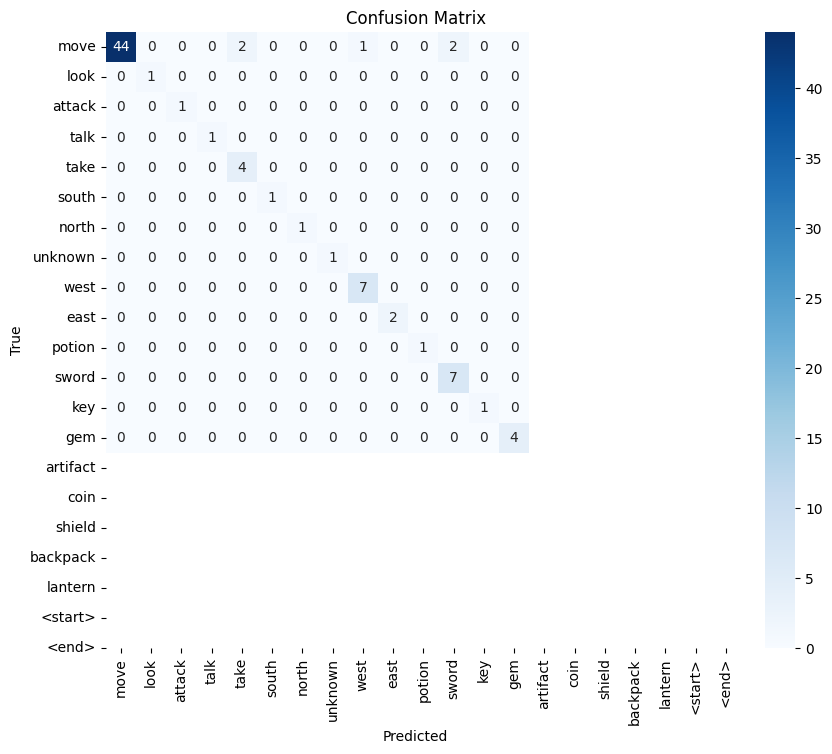

              precision    recall  f1-score   support

                   1.00      0.90      0.95        49
    artifact       1.00      1.00      1.00         1
    backpack       1.00      1.00      1.00         1
        coin       1.00      1.00      1.00         1
        east       0.67      1.00      0.80         4
         gem       1.00      1.00      1.00         1
         key       1.00      1.00      1.00         1
     lantern       1.00      1.00      1.00         1
       north       0.88      1.00      0.93         7
      potion       1.00      1.00      1.00         2
      shield       1.00      1.00      1.00         1
       south       0.78      1.00      0.88         7
       sword       1.00      1.00      1.00         1
        west       1.00      1.00      1.00         4

    accuracy                           0.94        81
   macro avg       0.95      0.99      0.97        81
weighted avg       0.95      0.94      0.94        81



In [10]:
# Make predictions
y_pred = model.predict([X_train, y_train_input])

# Convert predictions to text
predictions = np.argmax(y_pred, axis=-1)

# Convert target sequences back to words
def sequences_to_text(sequences, tokenizer):
    return [' '.join([tokenizer.index_word.get(i, '') for i in seq if i != 0]) for seq in sequences]

# Convert predictions and targets to text
y_pred_text = sequences_to_text(predictions, target_tokenizer)
y_true_text = sequences_to_text(y_train_output, target_tokenizer)

# Confusion Matrix
cm = confusion_matrix(np.ravel(y_true_text), np.ravel(y_pred_text))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_tokenizer.index_word.values(), yticklabels=target_tokenizer.index_word.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(np.ravel(y_true_text), np.ravel(y_pred_text)))


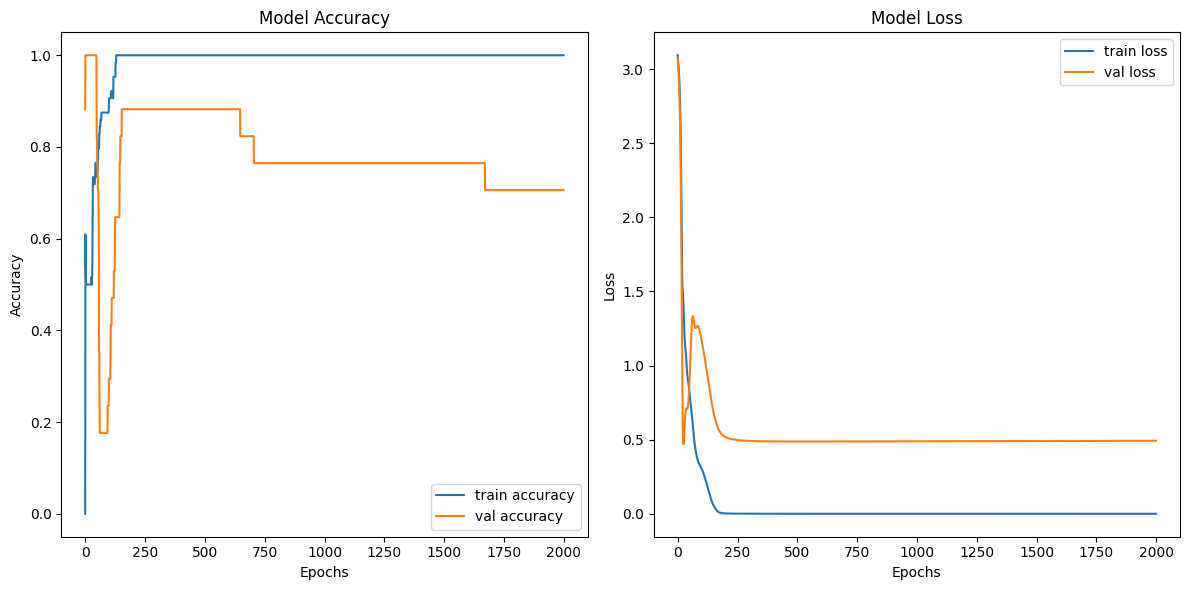

In [11]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
